In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

Загрузим [данные](https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/) о площади лесных пожаров на севере Португалии.

In [2]:
data = pd.read_csv('forestfires.csv')
data.shape

(517, 13)

In [3]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Проверим, что в таблице все ячейки заполнены:

In [4]:
data.isnull().values.any()

False

Приведем категориальные признаки к числовому для построения зависимости целевого признака от остальных.

In [5]:
d1 = {'jan': 1, 'feb' : 2, 'mar' : 3, 'apr' : 4, 'may' : 5, 'jun' : 6, 
      'jul' : 7, 'aug' : 8, 'sep' : 9, 'oct' : 10, 'nov' : 11, 'dec' : 12,
    'mon' : 1, 'tue' : 2, 'wed' : 3, 'thu' : 5, 'fri' : 5, 'sat' : 6, 'sun' : 7}

In [6]:
df = data.replace(d1)

Построим зависимости целевого признака от остальных

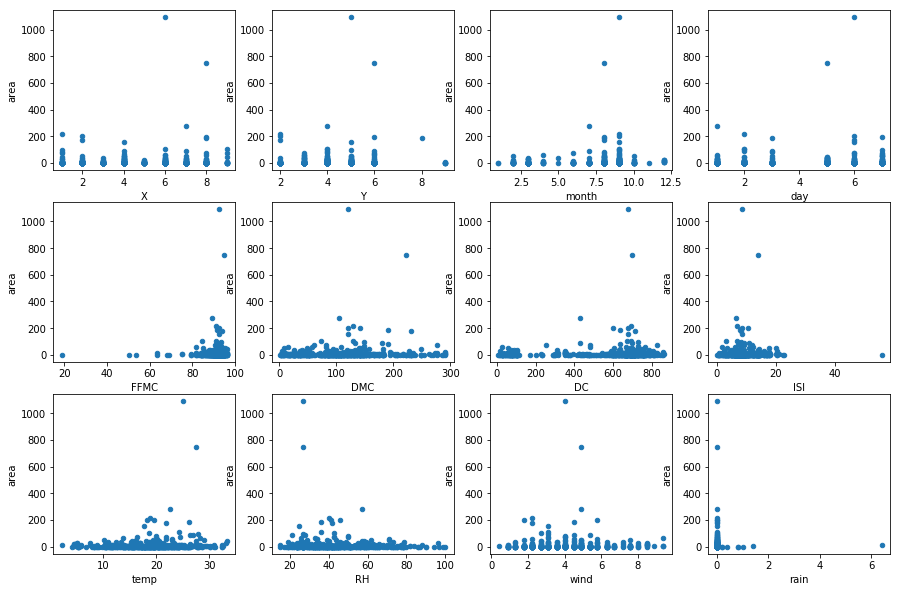

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "area", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Переведем значения 'area' в логарифмический масштаб.

In [8]:
df['area'] = df['area'].apply(lambda x: np.log(x+1))

Графики зависимости площади от признаков будут следующими:

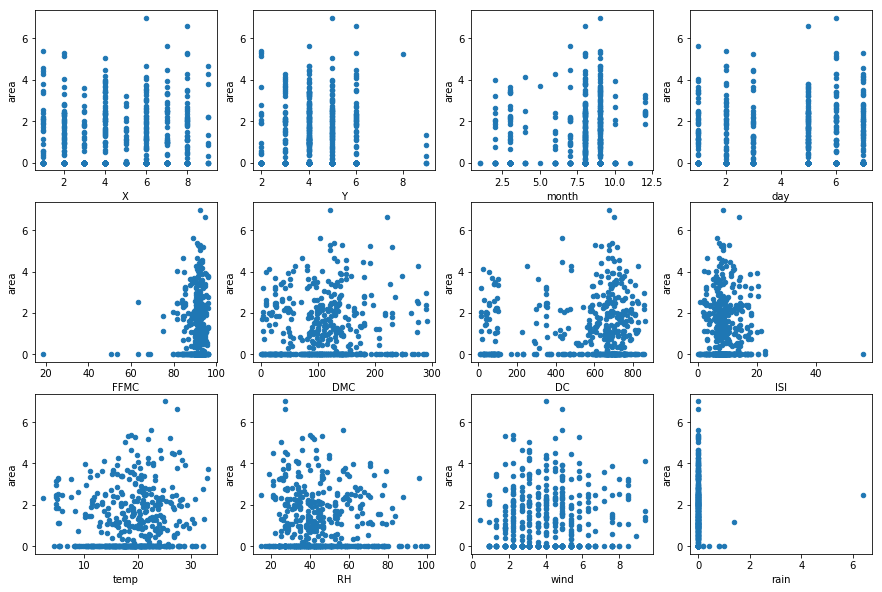

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "area", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Посмотрим на зависимость площади выгоревших лесов от координат.

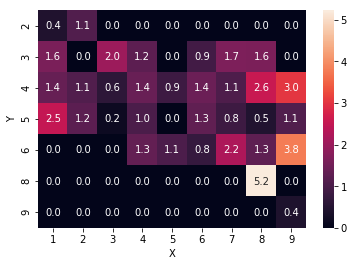

In [10]:
heat_point = df.pivot_table(index = 'Y', columns = 'X', values = 'area', aggfunc = np.mean).fillna(0)
sns.heatmap(heat_point, annot=True, fmt=".1f")

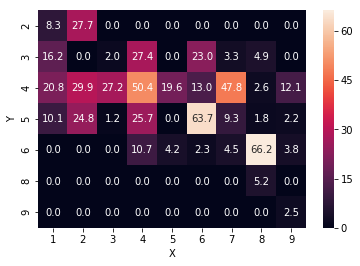

In [11]:
heat_point = df.pivot_table(index = 'Y', columns = 'X', values = 'area', aggfunc = sum).fillna(0)
sns.heatmap(heat_point, annot=True, fmt=".1f")

Отсюда видно, что площадь выгоревших пожаов не имеет линейной зависимости от координат. При этом видны точки, в которых пожары наиболее вероятны. Поэтому при построении модели вместо признаков X и Y создадим признак (X, Y).

In [12]:
data['coordinates'] = list(zip(data['X'], data['Y']))
data.drop(['X', 'Y'], axis = 1, inplace=True)

In [13]:
data['area'] = data['area'].apply(lambda x: np.log(x+1))

In [14]:
data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,coordinates
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,"(7, 5)"
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,"(7, 4)"
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,"(7, 4)"
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,"(8, 6)"
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,"(8, 6)"


Перемешаем выборку перед обучением.

In [15]:
from sklearn.utils import shuffle
df_sh = shuffle(data, random_state = 362)
X = df_sh.drop('area', 1)
y = df_sh['area']

Проведем преобразование категориальных признаков

In [16]:
categorical_cols = ['coordinates', 'month', 'day']
num_cols = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
X_cat = X[categorical_cols]
X_cat = X_cat.astype(str)
X_num = X[num_cols]

In [17]:
from sklearn.feature_extraction import DictVectorizer as DV

In [18]:
encoder = DV(sparse = False)
enc = encoder.fit_transform(X_cat.T.to_dict().values())
X_cat_oh = pd.DataFrame(dict(zip(encoder.feature_names_, enc.T)))
X_data = np.hstack((X_num, X_cat_oh))
X_data_keys = X_num.columns.append(X_cat_oh.columns)

## Логистическая регрессия с L1- и L2-регуляризациями.

Построим график общей ошибки на кросс-валидации при изменении параметра регуляризации в случае L1(lasso)-регуляризации и получим веса, соответствующие коэффиценту регуляризации, доставляющему минимум ошибке.

Chosen alpha is 0.009000000000000001
('FFMC', 0.011602076226956814)
('DMC', 0.0022682098453724025)
('DC', -0.0005679399318611318)
('ISI', -0.018143040863083684)
('temp', 0.013844194613706324)
('RH', -0.0026429124345234223)
('wind', 0.07105870557132174)
('rain', 0.0)
('coordinates=(1, 2)', -0.4604432825341082)
('coordinates=(1, 3)', 0.0)
('coordinates=(1, 4)', 0.0)
('coordinates=(1, 5)', 0.0)
('coordinates=(2, 2)', 0.0)
('coordinates=(2, 3)', -0.0)
('coordinates=(2, 4)', -0.0)
('coordinates=(2, 5)', 0.0)
('coordinates=(3, 3)', 0.0)
('coordinates=(3, 4)', -0.40290560135872794)
('coordinates=(3, 5)', -0.16407605464789074)
('coordinates=(3, 6)', -0.0)
('coordinates=(4, 3)', 0.0)
('coordinates=(4, 4)', 0.049137199904776226)
('coordinates=(4, 5)', -0.0)
('coordinates=(4, 6)', 0.0)
('coordinates=(5, 4)', -0.11190096162571936)
('coordinates=(5, 5)', -0.0)
('coordinates=(5, 6)', -0.0)
('coordinates=(6, 3)', -0.09099284996373103)
('coordinates=(6, 4)', 0.0)
('coordinates=(6, 5)', 0.0829246137678

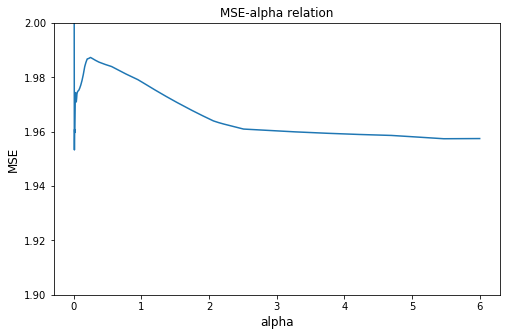

In [19]:
from sklearn.linear_model import LassoCV

alphas = np.arange(0.001, 6, 0.001)
lasso = LassoCV(alphas = alphas)
lasso.fit(X_data, y)

plt.figure(figsize=(8, 5))
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis = 1))
plt.xlabel("alpha", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("MSE-alpha relation")
# plt.xlim((100, 400))
plt.ylim((1.9, 2))
print('Chosen alpha is', lasso.alpha_)
for w in zip(X_data_keys, lasso.coef_):
    print (w)

Построим график общей ошибки на кросс-валидации при изменении параметра регуляризации в случае L2(Ridge)-регуляризации.

Chosen alpha is 210.1


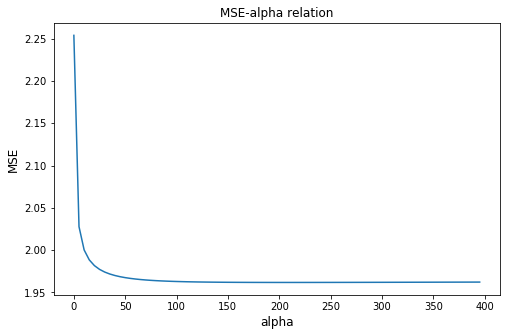

In [20]:
from sklearn.linear_model import RidgeCV

alphas = np.arange(0.1, 400, 5.0)
ridge = RidgeCV(alphas = alphas, store_cv_values=True)
ridge.fit(X_data, y)

plt.figure(figsize=(8, 5))
plt.plot(alphas, ridge.cv_values_.mean(axis = 0))
plt.xlabel("alpha", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("MSE-alpha relation")
print('Chosen alpha is', ridge.alpha_)
# for w in zip(names, ridge.coef_):
#     print (w)

## Логистическая регрессия с L1- и L2-регуляризациями в случае стандартизированных признаков.

Стандартизируем количесвтенные признаки. Построим аналогичные графики для случая стандартизированных признаков.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_num, y)
X_num_scaled = scaler.transform(X_num)
X_scaled = np.hstack((X_num_scaled, X_cat_oh))

Chosen alpha is 0.030000000000000002
('FFMC', 0.0)
('DMC', 0.05250987698187371)
('DC', 0.04864521912171724)
('ISI', -0.028315183345401354)
('temp', 0.0)
('RH', -0.05665728670539332)
('wind', 0.08595403567922923)
('rain', 0.0)


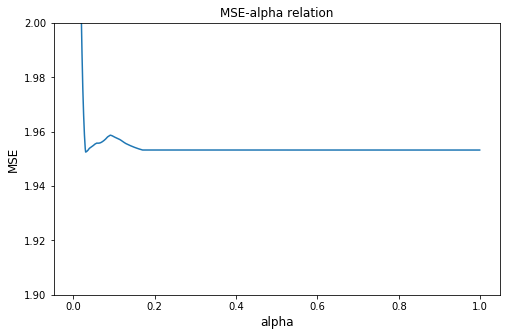

In [22]:
alphas = np.arange(0.001, 1, 0.001)
lasso = LassoCV(alphas = alphas)
lasso.fit(X_num_scaled, y)

plt.figure(figsize=(8, 5))
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis = 1))
plt.xlabel("alpha", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.ylim((1.9, 2))

plt.title("MSE-alpha relation")
print('Chosen alpha is', lasso.alpha_)
for w in zip(X_data_keys, lasso.coef_):
    print (w)

Chosen alpha is 730.1
('FFMC', 0.017670714418650188)
('DMC', 0.03114989748680722)
('DC', 0.025848438996708474)
('ISI', -0.021345525233390415)
('temp', 0.01816393031384804)
('RH', -0.028191297708055008)
('wind', 0.047330699643294005)
('rain', 0.012329959951055468)
('coordinates=(1, 2)', -0.017514173168124963)
('coordinates=(1, 3)', 0.006216501529394151)
('coordinates=(1, 4)', 0.004858948919740092)
('coordinates=(1, 5)', 0.007308353966439023)
('coordinates=(2, 2)', 0.00016834055680152362)
('coordinates=(2, 3)', -0.0016374172655731158)
('coordinates=(2, 4)', -0.0004947069649023717)
('coordinates=(2, 5)', 0.002829515371037967)
('coordinates=(3, 3)', 0.0011324934135807608)
('coordinates=(3, 4)', -0.026391975955929285)
('coordinates=(3, 5)', -0.008609259902476752)
('coordinates=(3, 6)', -0.005902235295845109)
('coordinates=(4, 3)', 0.0038578928150099115)
('coordinates=(4, 4)', 0.013269237279201557)
('coordinates=(4, 5)', -0.0023083142142301524)
('coordinates=(4, 6)', 0.003077482901861539)
('

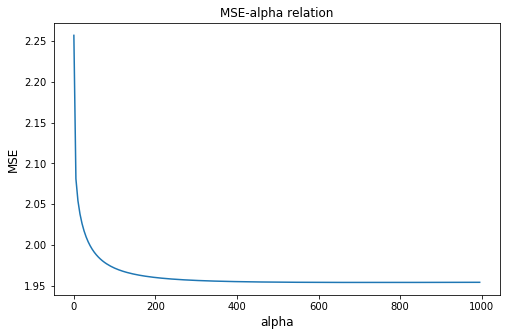

In [23]:
alphas = np.arange(0.1, 1000, 5)
ridge = RidgeCV(alphas = alphas, store_cv_values=True)
ridge.fit(X_scaled, y)

plt.figure(figsize=(8, 5))
plt.plot(alphas, ridge.cv_values_.mean(axis=0))
plt.xlabel("alpha", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("MSE-alpha relation")
print('Chosen alpha is', ridge.alpha_)
for w in zip(X_data_keys, ridge.coef_):
    print (w)

## Графики зависимости весов признаков при изменении параметра регуляризации.

Text(0.5,1,'Ridge')

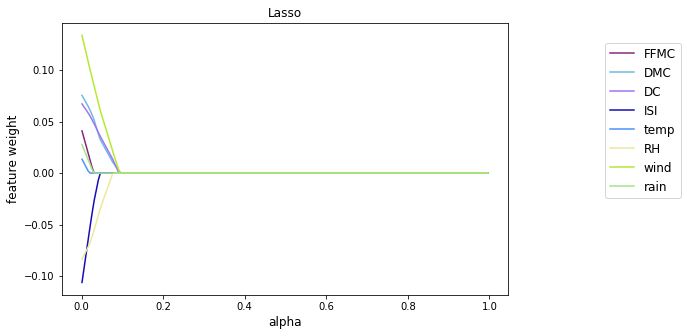

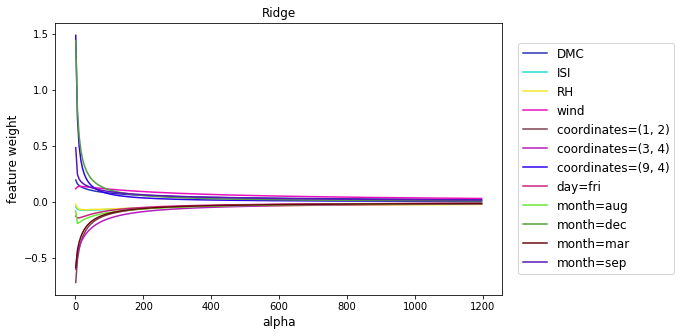

In [24]:
from sklearn.linear_model import Ridge, Lasso

alphasL = np.arange(0.001, 1, 0.005)
alphasR = np.arange(1, 1200, 5.0)
coefs_lasso = np.zeros((alphasL.shape[0], X_num_scaled.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphasR.shape[0], X_scaled.shape[1]))
# Для каждого значения коэффициента из alphas обучим регрессор Lasso
# и запишим веса в соответствующую строку матрицы coefs_lasso,
# а затем обучим Ridge и запишим веса в coefs_ridge.
for i, a in enumerate(alphasL):
    lasso_reg = Lasso(alpha = a)
    lasso_reg.fit(X_num_scaled, y)
    coefs_lasso[i] += lasso_reg.coef_
for i, a in enumerate(alphasR):
    ridge_reg = Ridge(alpha = a)
    ridge_reg.fit(X_scaled, y)
    coefs_ridge[i] += ridge_reg.coef_
    
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, X_data_keys):
    plt.plot(alphasL, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95), fontsize=12)
plt.xlabel("alpha", fontsize=12)
plt.ylabel("feature weight", fontsize=12)
plt.title("Lasso")


plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, X_data_keys):
    if np.abs(coef).mean() > 0.03:
        plt.plot(alphasR, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95), fontsize=12)
plt.xlabel("alpha", fontsize=12)
plt.ylabel("feature weight", fontsize=12)
plt.title("Ridge")

# Отчет

Для прогнозирования площади лесных пожаров были использованы логистические регрессии с L1- и L2-регуляризациями. Было получено, что на площадь лесных пожаров влияют больше всего такие признаки, как DMC, RH, ISI, wind. При этом были определены координаты мест, в которых наиболее вероятны пожары.